<a href="https://colab.research.google.com/github/SantiQuinteros/Curso-Ciencia-Datos-FING/blob/main/Script/Tarea%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a la Ciencia de Datos: Tarea 1

Este notebook contiene el código de base para realizar la Tarea 1 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd).

Se utiliza el lenguaje Python y la librería Pandas. Si no tiene ninguna familiaridad con la librería, se recomienda realizar algún tutorial introductorio (ver debajo).
También se espera que los alumnos sean proactivos a la hora de consultar las documentaciones de las librerías y del lenguaje, para entender el código provisto.
Además de los recursos provistos en la [página del curso](https://eva.fing.edu.uy/course/view.php?id=1378&section=1), los siguientes recursos le pueden resultar interesantes:
 - [Pandas getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) y [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html): Son parte de la documentación en la página oficial de Pandas.
 - [Kaggle Learn](https://www.kaggle.com/learn): Incluye tutoriales de Python y Pandas.


Si desea utilizar el lenguaje R y está dispuesto a no utilizar (o traducir) este código de base, también puede hacerlo.

En cualquier caso, **se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos (`requirements.txt`) en el mismo entorno donde está ejecutando este notebook (ver [README](https://github.com/DonBraulio/introCD)).

In [2]:
from time import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
#!pip install ydata_profiling
from ydata_profiling import ProfileReport
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=28111cab21877b20987501bab3842c54967548260db1c4e1f0a32b06aa529db9
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lectura de Datos

In [3]:
url = "https://raw.githubusercontent.com/SantiQuinteros/Curso-Ciencia-Datos-FING/refs/heads/main/Datos/us_2020_election_speeches.csv"

In [4]:
df = pd.read_csv(url)

# Parte 1: Cargado y Limpieza de Datos

## Exploración de Datos

### Exploración general

In [5]:
ID = 'Original'

profile_df = ProfileReport(df, title="Perfil de Datos " + ID)
profile_df

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Casos diferentes

Se ven casos nulos, casos que no permiten identificar al speaker ('???'), casos con más de un speaker identificado, casos que identificarían múltiples speakers no explícitos ('Multiple Speakers', 'Democratic Candidates').

In [6]:
n_filas, n_columnas = df.shape
print(f"Número total de filas del df original: {n_filas}")

Número total de filas del df original: 269


In [7]:
# Cantidad de filas con speaker nulo
n_filas_nulo = df['speaker'].isnull().sum()

print(f"Número de filas nulas: {n_filas_nulo}")
print("Porcentaje de filas nulas: ", round(n_filas_nulo/n_filas * 100 , 1), "%")

df[df['speaker'].isnull()]

Número de filas nulas: 3
Porcentaje de filas nulas:  1.1 %


,speaker,title,text,date,location,type
151,NaN,Democratic National Convention (DNC) 2020 Nigh...,Speaker 1: (00:00)\n(Silence).\nSpeaker 1: (21...,"Aug 19, 2020",NaN,NaN
156,NaN,Democratic National Convention (DNC) 2020 Nigh...,Speaker 1: (00:53)\nJoe Biden picking up not o...,"Aug 18, 2020",NaN,NaN
163,NaN,Democratic National Convention (DNC) 2020 Nigh...,"Intro: (00:05)\nJustice, strength, liberty.\nI...","Aug 17, 2020","Milwaukee, Wisconsin",Campaign Speech


In [8]:
# Lista de speakers no identificados
filas_unknown = ['???', 'Multiple Speakers', 'Democratic Candidates']

n_filas_unknown = df[df['speaker'].isin(filas_unknown)]['speaker'].count()
print(f"Número de filas con speaker desconocido : {n_filas_unknown}")
print("Porcentaje de filas con speaker desconocido : ", round(n_filas_unknown/n_filas * 100 , 1), "%")

df[df['speaker'].isin(filas_unknown)]

Número de filas con speaker desconocido : 14
Porcentaje de filas con speaker desconocido :  5.2 %


,speaker,title,text,date,location,type
106,Multiple Speakers,2020 Republican National Convention (RNC) Nigh...,Speaker 1: (00:11)\nSomeone once said that Ame...,"Aug 28, 2020","Charlotte, North Carolina",Campaign Speech
114,Multiple Speakers,2020 Republican National Convention (RNC) Nigh...,"Speaker 1: (00:00)\nThing, it was never intend...","Aug 27, 2020","Charlotte, North Carolina",Campaign Speech
124,Multiple Speakers,2020 Republican National Convention (RNC) Nigh...,Speaker 1: (00:00)\nWe hold these truths to be...,"Aug 26, 2020","Charlotte, North Carolina",Campaign Speech
132,Multiple Speakers,2020 Republican National Convention (RNC) Nigh...,Speaker 1: (27:54)\nA country where we are jud...,"Aug 25, 2020","Charlotte, North Carolina",Campaign Speech
140,Multiple Speakers,2020 Democratic National Convention (DNC) Nigh...,Speaker 1: (00:33)\nI’m here by calling the fu...,"Aug 21, 2020","Milwaukee, Wisconsin",Campaign Speech
194,???,Joe Biden & Trump Surrogates Hold Town Hall fo...,"Vicky Nguyen: (08:06)\nHi, everyone. I’m inves...","Jun 27, 2020",NaN,NaN
234,Democratic Candidates,"Super Tuesday Speech Transcripts: Biden, Sande...",Joe Biden: (00:51)\nHello. Hello. Hello. Hello...,"Mar 3, 2020",NaN,Campaign Speech
244,Democratic Candidates,South Carolina Democratic Debate Transcript: F...,Norah O’Donnell: (00:16)\nGood evening and wel...,"Feb 26, 2020","Charleston, South Carolina",Debate
246,Democratic Candidates,Nevada Caucus Speech Transcripts: Bernie Sande...,"Audience: (00:00)\nBernie, Bernie, Bernie …\nB...","Feb 22, 2020",NaN,Campaign Speech
252,Democratic Candidates,"Democratic Debate Transcript: Las Vegas, Nevad...",Lester Holt: (00:00)\nGood evening everyone. I...,"Feb 20, 2020","Las Vegas, Nevada",Debate


In [9]:
# Total de casos con speaker desconocido
n_filas_especiales = n_filas_nulo + n_filas_unknown
print(f"Número de filas especiales : {n_filas_especiales}")
print("Porcentaje de filas especiales : ", round(n_filas_especiales/n_filas * 100 , 1), "%")

Número de filas especiales : 17
Porcentaje de filas especiales :  6.3 %


También hay casos especiales, en los que un mismo discurso tiene asignado más de un speaker

In [10]:
# Cantidad de filas con speaker combinado
# Filas que contienen el carácter "," en la columna "speaker"
n_filas_mixtas = df['speaker'].str.contains(',').sum()

print(f"Número de filas que contienen ',': {n_filas_mixtas}")
print("Porcentaje de filas con más de un speaker: ", round(n_filas_mixtas/n_filas * 100 , 1), "%")

df[df['speaker'].str.contains(',', na=False)]

Número de filas que contienen ',': 14
Porcentaje de filas con más de un speaker:  5.2 %


,speaker,title,text,date,location,type
20,"Lindsey Graham, Jaime Harrison",Lindsey Graham vs. Jaime Harrison Debate Forum...,"Speaker 1: (00:00)\nBut right now, we’re going...","Oct 10, 2020","Spartanburg, South Carolina",Debate
23,"Joe Biden,Kamala Harris",Joe Biden & Kamala Harris Campaign Event Phoen...,Speaker 1: (00:00)\nPlease welcome to the stag...,"Oct 8, 2020","Phoenix, Arizona",Campaign Speech
26,"Kamala Harris, Mike Pence",Kamala Harris & Mike Pence 2020 Vice President...,Susan Page: (00:00)\nGood evening. From the Un...,"Oct 7, 2020","Salt Lake City,Utah",Debate
32,"Lindsey Graham, Jaime Harrison",Lindsey Graham vs. Jaime Harrison SC Senate De...,Judi (Moderator): (00:15)\nBecause camera angl...,"Oct 4, 2020","Columbia, South Carolina",Debate
46,"Donald Trump, Joe Biden",Donald Trump & Joe Biden 1st Presidential Deba...,Chris Wallace: (01:20)\nGood evening from the ...,"Sep 29, 2020","Cleveland, Ohio",Debate
103,"Joe Biden,Kamala Harris",Joe Biden & Kamala Harris ‘A Socially Distance...,Kamala Harris: (00:30)\nMy career has been abo...,"Sep 1, 2020",NaN,Interview
174,"Joe Biden,Kamala Harris",Joe Biden and Kamala Harris Coronavirus Speech...,Joe Biden: (00:01)\nWe talked about school ope...,"Aug 13, 2020","Wilmington, Delaware",NaN
175,"Joe Biden,Kamala Harris",Joe Biden and Kamala Harris Speech Transcript ...,Joe Biden: (17:08)\nPlease welcome Vice Presid...,"Aug 12, 2020","Wilmington, Delaware",NaN
184,"Joe Biden, Barack Obama",Joe Biden Campaign Video with Barack Obama Tra...,Vice President Joe Biden: (00:06)\nCan you ima...,"Jul 23, 2020",Virtual,Campaign Speech
201,"Joe Biden,Tom Wolf",Joe Biden Virtual Meeting Transcript With PA G...,Governor Tom Wolf: (00:00)\nPresident even sup...,"May 27, 2020",Pennsylvania,Interview


Para estos casos generamos una linea por speaker, para separarlos y que la columna speaker identifique unicamente una persona.

In [11]:
df = df.assign(speaker=df['speaker'].str.split(',')).explode('speaker').reset_index(drop=True)

### Top 5

In [12]:
conteo = df['speaker'].value_counts()

top_5 = conteo.head(5)

print(top_5)

speaker
Joe Biden         80
Donald Trump      54
Mike Pence        19
Kamala Harris     16
Bernie Sanders    16
Name: count, dtype: int64


<ipython-input-14-294a1ed8441d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='count', y='speaker', data=top_5, palette='crest')


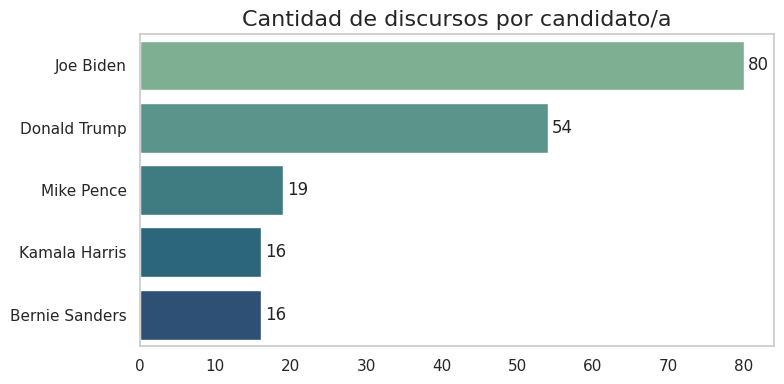

In [14]:
top_5 = pd.DataFrame(top_5)
top_5 = top_5.reset_index()

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))

ax = sns.barplot(x='count', y='speaker', data=top_5, palette='crest')

plt.title('Cantidad de discursos por candidato/a', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fmt='{:,.0f}', label_type='edge', padding=3)

plt.tight_layout()
plt.grid(False)
plt.show()

In [15]:
top_5_speaker = conteo.head(5).index.tolist()

df_speeches_top_5 = df[df['speaker'].isin(top_5_speaker)]

print(df_speeches_top_5['speaker'].value_counts())


speaker
Joe Biden         80
Donald Trump      54
Mike Pence        19
Kamala Harris     16
Bernie Sanders    16
Name: count, dtype: int64


## Visualizaciones

In [16]:
# CONVERTIR LA COLUMNA A FORMATO FECHA
df_speeches_top_5['date'] = pd.to_datetime(df_speeches_top_5['date'])

<ipython-input-16-7771df14bf5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['date'] = pd.to_datetime(df_speeches_top_5['date'])


### Gráficos

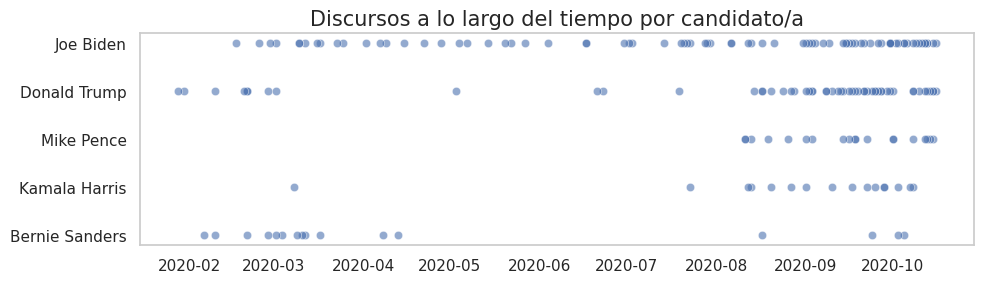

In [17]:
plt.figure(figsize=(10,3))

sns.scatterplot(data=df_speeches_top_5, x='date', y='speaker', alpha=0.6,  palette='crest')

plt.title('Discursos a lo largo del tiempo por candidato/a', fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.grid(False)
plt.tight_layout()
plt.show()

In [18]:
df_speeches_top_5['month'] = df_speeches_top_5['date'].dt.to_period('M')

df_mes = df_speeches_top_5.groupby(['month', 'speaker']).size().reset_index(name='count')

df_mes['month'] = df_mes['month'].dt.to_timestamp()

<ipython-input-18-27eeda2d3e6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['month'] = df_speeches_top_5['date'].dt.to_period('M')


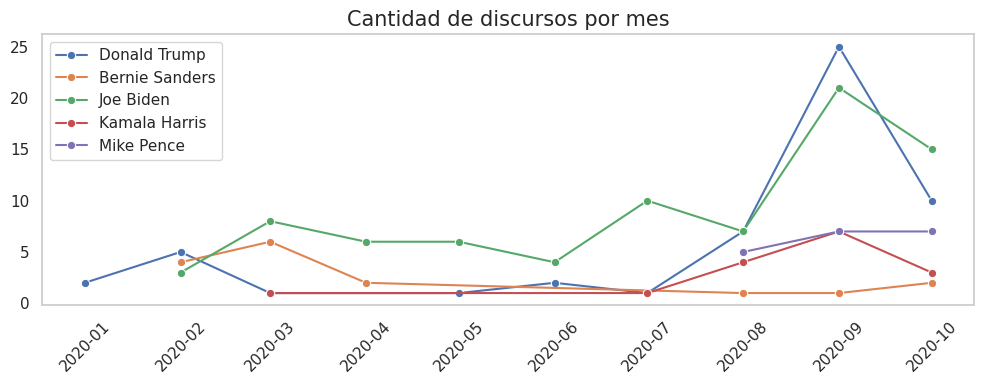

In [19]:
plt.figure(figsize=(10,4))
sns.lineplot(data=df_mes, x='month', y='count', hue='speaker', marker='o')

plt.title('Cantidad de discursos por mes', fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.legend(title = '')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


Observaciones:


*   Hay picos en los discursos de 3 de las 5 personas en setiembre 2020
*   Los candidatos con más discursos son Trump y Biden
*   Mike Pence aparece en Agosto 2020 (el resto aparece desde antes)



## Limpieza de Texto y Conteo de Palabras

### Limpieza nombre candidato

En la primera fila, por ejemplo, se ve que cada vez que habla el speaker su nombre vuelve a aparecer junto con el minuto en el que habla. Eso hace que teóricamente diga su propio nombre varias veces. También suelen aparecer otros speakers.

Tambien hay filas en que se refieren al speaker con otro nombre, por ejemplo, en el caso de Donald Trump lo mencionan como President Trump. Por eso, cambiaremos el texto para reflejar correctamente el speaker.

In [20]:
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Trump', "Donald Trump")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Donald J. Trump', "Donald Trump")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Donald J. Trump', "Donald Trump")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Senator Harris', "Kamala Harris")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Vice President Mike Pence ', "Mike Pence")
df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('Vice President Biden', "Joe Biden")

<ipython-input-20-c09d1841d43e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Trump', "Donald Trump")
<ipython-input-20-c09d1841d43e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['text'] = df_speeches_top_5['text'].str.replace('President Donald J. Trump', "Donald Trump")
<ipython-input-20-c09d1841d43e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Importar texto por candidato

Generamos una funcion para quedarnos solamente con los discursos del speaker en cuestion

In [21]:
def extract_speaker_phrases(text, speaker):

    speaker_escaped = re.escape(speaker)

    pattern = rf'({speaker_escaped}:.*?\n.*?\n)'
    matches = re.findall(pattern, text, re.DOTALL)
    return [m.strip() for m in matches]

In [22]:
df_speeches_top_5['Phrases'] = df_speeches_top_5.apply(lambda row: extract_speaker_phrases(row['text'], row['speaker']), axis=1)

<ipython-input-22-4b736a709c66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases'] = df_speeches_top_5.apply(lambda row: extract_speaker_phrases(row['text'], row['speaker']), axis=1)


Quitamos del discurso el nombre del speaker y los minutos, dado que no forman parte de las palabras que dijo

In [23]:
def clean_phrase(phrase, speaker):

    speaker_pattern = rf'{re.escape(speaker)}:\s*\(\d{{2}}:\d{{2}}\)\s*\n'
    cleaned = re.sub(speaker_pattern, '', phrase)
    return cleaned.strip()

In [24]:
df_speeches_top_5['Phrases'] = df_speeches_top_5.apply(
    lambda row: [clean_phrase(p, row['speaker']) for p in row['Phrases']],
    axis=1
)

<ipython-input-24-bef36f99777f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases'] = df_speeches_top_5.apply(


# Parte 2: Conteo de Palabras y Visualizaciones

 ## Candidatos con mayor cantidad de palabras

In [25]:
# TODO: Realice una visualización que permita comparar las palabras más frecuentes de cada uno de los cinco candidatos/as.
# - Encuentra algún problema en los resultados?


In [26]:
def clean_text(df, column_name):
    def clean_phrase_list(phrases):
        if not isinstance(phrases, list):
            return phrases
        cleaned = []
        for phrase in phrases:

            phrase = str(phrase).lower()
            for punc in ["\n", ",", ":", "?", ".", "(", ")", "1","2","3","4","5","6","7","8","9","0","...","“","”", "…", ",", ",", "[", "]", "we’re", "it’s", "i’m", "!",";",
                         "she’s",  "didn’t", "i’ll", "weren’t", "mightn’t", "he’d","she’ll", "you’re", "isn’t", "we’ve", "he’ll", "they’ve", "should’ve", "you’ve", "you’ll", "we’re","haven’t", "hadn’t","we’ll", "won’t", "doesn’t", "hasn’t","he’s", "i’ve", "aren’t", "they’d", "wasn’t", "couldn’t", "she’d", "we’d", "they’ll", "they’re", "shouldn’t", "wouldn’t", "i’d", "shan’t", "that’ll", "you’d", "don’t", "needn’t", "mustn’t", "it’ll", "it’d", "it’s"]:
                phrase = phrase.replace(punc, " ")
            cleaned.append(phrase.strip())
        return cleaned

    return df[column_name].apply(clean_phrase_list)


In [27]:
df_speeches_top_5['Phrases_2'] = clean_text(df_speeches_top_5, 'Phrases')

<ipython-input-27-ca3edfd73b38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases_2'] = clean_text(df_speeches_top_5, 'Phrases')


Separa las frases en palabras dentro de una lista

In [28]:
df_speeches_top_5['Phrases_2'] = df_speeches_top_5['Phrases_2'].apply(
    lambda phrase: [word for word in str(phrase).split() if word]
)

<ipython-input-28-b30c1661d77a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases_2'] = df_speeches_top_5['Phrases_2'].apply(


Quitamos de las palabras los conectores en ingles, para quedarnos con las palabras significantes

In [29]:
stop_words = set(stopwords.words('english'))

df_speeches_top_5['Phrases_2'] = df_speeches_top_5['Phrases_2'].apply(
    lambda words: [word for word in words if word.lower() not in stop_words]
)

<ipython-input-29-66e6ca647d0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speeches_top_5['Phrases_2'] = df_speeches_top_5['Phrases_2'].apply(


Contar las palabras que dijo cada candidato

In [30]:
top_palabras = []

for speaker, group in df_speeches_top_5.groupby('speaker'):
    todas_las_palabras = sum(group['Phrases_2'], [])

    conteo = Counter(todas_las_palabras)

    top_5 = conteo.most_common(5)

    for palabra, cantidad in top_5:
        top_palabras.append({'speaker': speaker, 'palabra': palabra, 'conteo': cantidad})

conteo_por_speaker = pd.DataFrame(top_palabras)
conteo_por_speaker = conteo_por_speaker.sort_values(['speaker', 'conteo'], ascending=[True, False])


In [31]:
conteo_por_speaker

,speaker,palabra,conteo
0,Bernie Sanders,people,383
1,Bernie Sanders,country,216
2,Bernie Sanders,going,212
3,Bernie Sanders,american,125
4,Bernie Sanders,need,121
5,Donald Trump,going,3364
6,Donald Trump,said,2725
7,Donald Trump,people,2649
8,Donald Trump,know,2395
9,Donald Trump,great,2239


<ipython-input-32-466f86111b2a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_speaker, x='conteo', y='palabra', ax=ax, palette='crest')
<ipython-input-32-466f86111b2a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_speaker, x='conteo', y='palabra', ax=ax, palette='crest')
<ipython-input-32-466f86111b2a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_speaker, x='conteo', y='palabra', ax=ax, palette='crest')
<ipython-input-32-466f86111b2a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is

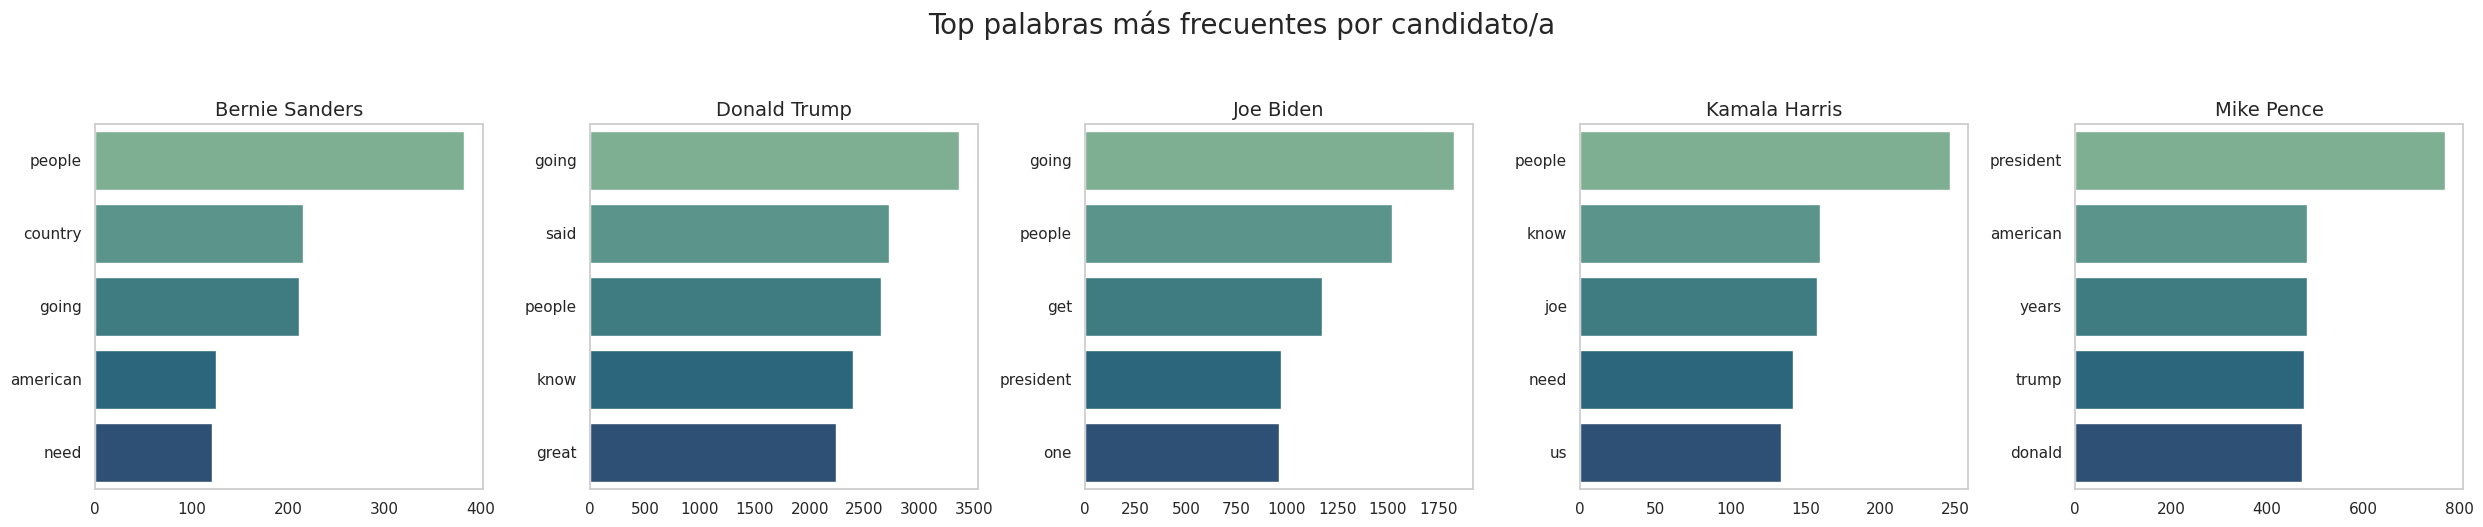

In [32]:
speakers = conteo_por_speaker['speaker'].unique()
n_speakers = len(speakers)

fig, axes = plt.subplots(nrows=1, ncols=n_speakers, figsize=(5 * n_speakers, 5), sharey=False)

if n_speakers == 1:
    axes = [axes]

for ax, speaker in zip(axes, speakers):
    data_speaker = conteo_por_speaker[conteo_por_speaker['speaker'] == speaker]
    sns.barplot(data=data_speaker, x='conteo', y='palabra', ax=ax, palette='crest')
    ax.set_title(f"{speaker}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(False)


plt.suptitle(f"Top palabras más frecuentes por candidato/a", fontsize=20, y=1.05)
plt.tight_layout()
plt.show()

Corra el código que permite encontrar los candidatos/as con mayor cantidad de
palabras. En caso de encontrar algún problema luego de realizar la visualización,
comente a qué se debe y proponga formas de resolverlo.


In [33]:
df_exploded = df_speeches_top_5.explode('Phrases_2')[['speaker', 'Phrases_2']]

In [34]:
df_exploded = df_exploded.rename(columns={
    'Phrases_2': 'palabras'
})

In [35]:
palabras_por_speaker = df_exploded.groupby('speaker').count().reset_index()

In [36]:
#palabras_por_speaker

In [37]:
palabras_por_speaker = palabras_por_speaker.sort_values(by='palabras', ascending=False)

El conteo ya depura las palabras genericas (and,to,etc), dejando solamente las que tienen un significado

<ipython-input-38-231b41844ff8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='palabras', y='speaker', data=palabras_por_speaker, palette='crest')


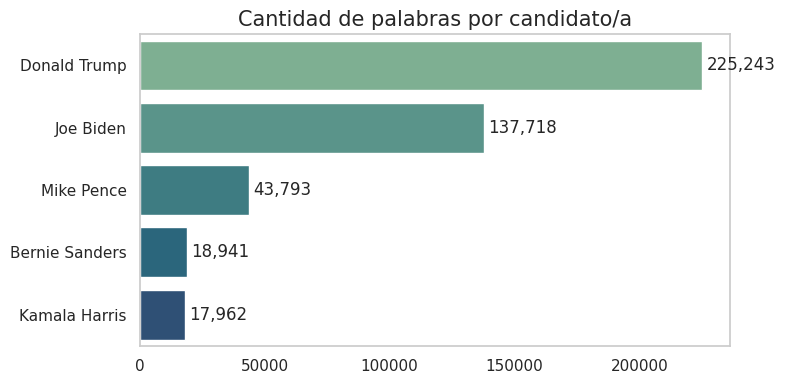

In [38]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))

ax = sns.barplot(x='palabras', y='speaker', data=palabras_por_speaker, palette='crest')

plt.title('Cantidad de palabras por candidato/a', fontsize=15)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fmt='{:,.0f}', label_type='edge', padding=3)

plt.tight_layout()
plt.grid(False)
plt.show()

## Menciones entre candidatos

Construya una matriz de 5x5, donde cada fila y columna corresponden a un
candiato/a, y la entrada (i,j) contiene la cantidad de veces que el candiato/a “i”
menciona al candiato/a “j”. Opcional: genere un grafo dirigido con esa matriz de
adyacencia para visualizar las menciones.

In [39]:
#df_exploded

In [40]:
nombres_candidatos = df_exploded[df_exploded['palabras'].isin(["donald", "trump", "joe", "biden", "mike", "pence", "bernie", "sanders", "kamala", "harris"])]

In [41]:
conteo_por_speaker = (
    nombres_candidatos
    .groupby(['speaker', 'palabras'])
    .size()
    .reset_index(name='conteo')
    .sort_values(['speaker', 'conteo'], ascending=[True, False])
)

In [42]:
conteo_por_speaker = conteo_por_speaker.reset_index(drop=True)

Buscar en phrases la palabra "Joe Biden" -> el numero final seria Joe + Biden - "Joe Biden"

In [43]:
reemplazos = {
    r"\bjoe\b": "Joe Biden",
    r"\bbiden\b": "Joe Biden",
    r"\bbernie\b": "Bernie Sanders",
    r"\bsanders\b": "Bernie Sanders",
    r"\bharris\b": "Kamala Harris",
    r"\bkamala\b": "Kamala Harris",
    r"\btrump\b": "Donald Trump",
    r"\bdonald\b": "Donald Trump",
    r"\bmike\b": "Mike Pence",
    r"\bpence\b": "Mike Pence"
}

conteo_por_speaker['palabras'] = conteo_por_speaker['palabras'].replace(reemplazos, regex=True)

In [44]:
conteo_por_speaker_vf = conteo_por_speaker.groupby(['speaker', 'palabras'])['conteo'].sum().reset_index()

Cantidad de veces que se mencionan los candidatos por nombre compleato

In [45]:
nombres_candidatos = ["Donald Trump", "Joe Biden", "Kamala Harris", "Mike Pence", "Bernie Sanders"]

resultados = []

for _, row in df_speeches_top_5.iterrows():
    speaker = row['speaker']
    phrases = row['Phrases']

    if isinstance(phrases, list):

        text = " ".join(phrases)
        for nombre in nombres_candidatos:
            conteo = text.count(nombre)
            if conteo > 0:
                resultados.append({
                    'speaker': speaker,
                    'palabras': nombre,
                    'conteo': conteo
                })

conteo_df = pd.DataFrame(resultados)


In [46]:
conteo_por_speaker_vf_2 = conteo_df.groupby(['speaker', 'palabras'])['conteo'].sum().reset_index()

In [47]:
conteo_por_speaker_vf_2 = conteo_por_speaker_vf_2.rename(columns={
    'conteo': 'conteo2'
})

Numero final de conteo por candidato= Nombre + Apellido - Nombre completo (Nombre y apellido)

In [48]:
conteo_por_speaker_vf_3 = pd.merge(conteo_por_speaker_vf, conteo_por_speaker_vf_2, on = ['speaker', 'palabras'], how = 'left')
conteo_por_speaker_vf_3 = conteo_por_speaker_vf_3.fillna(0)

In [49]:
conteo_por_speaker_vf_3['conteo_final'] = conteo_por_speaker_vf_3['conteo'] - conteo_por_speaker_vf_3['conteo2']

In [ ]:
#conteo_por_speaker_vf_3

Matriz final de menciones por candidato

In [50]:
matriz_5x5 = conteo_por_speaker_vf_3.pivot_table(index='speaker', columns='palabras', values='conteo_final', fill_value=0)

In [51]:
matriz_5x5.reset_index()

palabras,speaker,Bernie Sanders,Donald Trump,Joe Biden,Kamala Harris,Mike Pence
0,Bernie Sanders,6.0,104.0,121.0,0.0,0.0
1,Donald Trump,212.0,391.0,1115.0,86.0,221.0
2,Joe Biden,27.0,405.0,115.0,40.0,12.0
3,Kamala Harris,0.0,74.0,156.0,10.0,4.0
4,Mike Pence,4.0,472.0,368.0,53.0,26.0


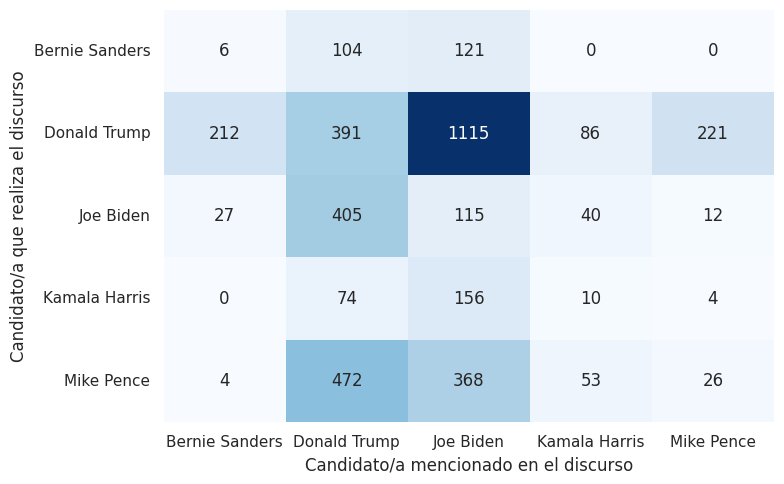

In [52]:
plt.figure(figsize=(8  , 5))
sns.heatmap(matriz_5x5, annot=True, fmt='.0f', cmap='Blues', cbar=False)

plt.title('')
plt.xlabel('Candidato/a mencionado en el discurso', fontsize = 12)
plt.ylabel('Candidato/a que realiza el discurso', fontsize = 12)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()